In [8]:
import scanpy as sc
import numpy as np
import scanpy.external as sce
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import cospar as cs

import sys
sys.path.append("/home/sergey/tools/scLiTr/")
import sclitr as sl

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

# Figures aesthetics
sc.set_figure_params(dpi=150)
sns.set_style("ticks")
sc.settings.figdir = "figures_comparison"

In [10]:
clones = sc.read_h5ad("/home/sergey/data/clonal_project/anndatas/merged_clones_trunk_E13/E13_clonal_embedding.h5ad")
clones = clones[clones.obs["leiden_0.5"].isin(["0", "1", "3", "4", "5"])].copy()

adata = sc.read_h5ad("../05_Example_of_usage/data/Erickson_trunk_mesenchyme.h5ad")
adata = adata[
    (adata.obs["E7.5:clones"] != "NA") |
    (adata.obs["E8.5:clones"] != "NA")
].copy()
adata = sl.pp.prepare_multiple_injections(
    adata,
    injection_cols=["E7.5:clones", "E8.5:clones"],
)
adata.obs["clone"] = [i.replace("clones_", "") for i in adata.obs.clone]
adata = adata[adata.obs.clone.isin(clones.obs_names)].copy()

cs.pp.get_X_clone(adata, adata.obs_names, adata.obs.clone)
adata.uns["data_des"] = ["my_data"]
adata.obs["time_info"] = "E13.5"
adata.obs["state_info"] = adata.obs["celltype_l2"].copy()

clones = clones[clones.obs_names.isin(adata.obs.clone)].copy()

/home/sergey/tools/scLiTr/sclitr/pp.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_demult.obs[final_obs_name] = clone_obs
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
100%|██████████| 24410/24410 [00:00<00:00, 1565440.82it/s]

reorder clones


In [102]:
clones_expr = sc.read_h5ad("/home/sergey/data/clonal_project/anndatas/merged_clones_trunk_E13/E13_clonal_embedding_expr.h5ad")

genes = np.array([
    "Hoxc13", "Hoxc12", "Hoxc11",
    "Hoxd11", "Hoxc10", "Hoxd9",
    "Hoxc8", "Hoxa7", "Hoxc6", "Hoxb5",
    "Hoxb4"
])

anterio_posterior_signature = dict(enumerate(genes[::-1]))
anterio_posterior_signature = dict(zip(anterio_posterior_signature.values(), [i + 1 for i in anterio_posterior_signature.keys()]))

clones_expr.obs["Hox_position"] = (
    clones_expr[:, list(anterio_posterior_signature.keys())].X *
    np.array(list(anterio_posterior_signature.values())) / 
    clones_expr[:, list(anterio_posterior_signature.keys())].X.sum(axis=1).T.A
)[0]

clones_expr.obs["Hox_position"] = (
    clones_expr.obs["Hox_position"] - clones_expr.obs["Hox_position"].min()
) / (clones_expr.obs["Hox_position"].max() - clones_expr.obs["Hox_position"].min())

clones_expr.obs["Hox_position"] = [i if str(i) != "nan" else 0.5 for i in clones_expr.obs["Hox_position"]]

/tmp/ipykernel_16114/2666614199.py:14: RuntimeWarning: invalid value encountered in divide
  clones_expr[:, list(anterio_posterior_signature.keys())].X *


In [11]:
clone_to_number = dict(zip(
    adata.obs.clone,
    np.argwhere(adata.obsm["X_clone"].A)[:, 1],
))

clones.obs["clone_number"] = [clone_to_number[i] for i in clones.obs_names]

## Standard approach

In [12]:
# Modified function to keep indicies of the clones during reordering
# original is cospar.plotting._utils.custom_hierachical_ordering()

def custom_hierachical_ordering(order_ids, matrix, pseudo_count=0.00001, col_indices=None):
    import numpy as np

    if col_indices is None:
        col_indices = np.arange(matrix.shape[1])

    if (len(order_ids) < 1) or (matrix.shape[1] < 2):
        return matrix, col_indices.tolist()

    order_ids = np.array(order_ids)
    valid_clone_idx = np.ones(matrix.shape[1], dtype=bool)
    new_data_list = []
    new_index_list = []

    for j, x in enumerate(order_ids):
        valid_clone_idx_tmp = valid_clone_idx & (matrix[x] > 0)
        data_matrix = matrix[:, valid_clone_idx_tmp].T
        data_indices = col_indices[valid_clone_idx_tmp]
        valid_clone_idx = valid_clone_idx & (~valid_clone_idx_tmp)

        if np.sum(valid_clone_idx_tmp) >= 2:
            order_y = cs.hf.get_hierch_order(data_matrix + pseudo_count)
            updated_matrix = data_matrix[order_y].T
            updated_indices = data_indices[order_y]
        else:
            updated_matrix = data_matrix.T
            updated_indices = data_indices

        updated_matrix_1, updated_indices_1 = custom_hierachical_ordering(
            order_ids[j + 1 :], updated_matrix, pseudo_count=pseudo_count, col_indices=updated_indices
        )
        new_data_list.append(updated_matrix_1)
        new_index_list.extend(updated_indices_1)

    # Add remaining columns that were not selected by any order_id
    new_data_list.append(matrix[:, valid_clone_idx])
    new_index_list.extend(col_indices[valid_clone_idx].tolist())

    return np.column_stack(new_data_list), new_index_list

In [34]:
# Modification of the cospar.pl.barcode_heatmap so it will use
# custom custom_hierachical_ordering function

def barcode_heatmap(
    adata,
    selected_times=None,
    selected_fates=None,
    color_bar=True,
    rename_fates=None,
    normalize=False,
    binarize=False,
    log_transform=False,
    fig_width=4,
    fig_height=6,
    figure_index="",
    plot=True,
    pseudocount=10 ** (-10),
    order_map_x=False,
    order_map_y=False,
    fate_normalize_source="X_clone",
    select_clones_with_fates: list = None,
    select_clones_without_fates: list = None,
    select_clones_mode: str = "or",
    **kwargs,
):
    data_des = adata.uns["data_des"][-1]
    data_des = f"{data_des}_clonal"

    coarse_X_clone, mega_cluster_list = cs.tl.coarse_grain_clone_over_cell_clusters(
        adata,
        selected_times=selected_times,
        selected_fates=selected_fates,
        normalize=normalize,
        fate_normalize_source=fate_normalize_source,
        select_clones_with_fates=select_clones_with_fates,
        select_clones_without_fates=select_clones_without_fates,
        select_clones_mode=select_clones_mode,
        **kwargs,
    )

    if rename_fates is None:
        rename_fates = mega_cluster_list

    if len(rename_fates) != len(mega_cluster_list):
        logg.warn(
            "rename_fates does not have the same length as selected_fates, thus not used."
        )
        rename_fates = mega_cluster_list

    if "x_ticks" not in kwargs.keys():
        kwargs["x_ticks"] = rename_fates

    coarse_X_clone_new, order_new = custom_hierachical_ordering(
        np.arange(coarse_X_clone.shape[0]), coarse_X_clone
    )
    adata.uns["barcode_heatmap"] = {
        "coarse_X_clone": coarse_X_clone,
        "fate_names": rename_fates,
    }
    if plot:
        if binarize:
            final_matrix = coarse_X_clone_new > 0
            color_bar_label = "Binarized barcode count"
        else:
            final_matrix = coarse_X_clone_new
            color_bar_label = "Barcode count"

        if normalize:
            color_bar_label += " (normalized)"

        clone_idx = final_matrix.sum(0) > 0
        ax = cs.plotting._utils.heatmap(
            final_matrix.T,
            order_map_x=order_map_x,
            order_map_y=order_map_y,
            color_bar_label=color_bar_label,
            log_transform=log_transform,
            fig_width=fig_width,
            fig_height=fig_height,
            color_bar=color_bar,
            **kwargs,
        )
        plt.title(f"{np.sum(clone_idx)} clones")

        plt.tight_layout()
        return coarse_X_clone_new, order_new

normalize by X_clone
each selected cluster has a unique time point. Normalize per time point
Data saved at adata.uns['barcode_heatmap']


<Axes: title={'center': '835 clones'}>

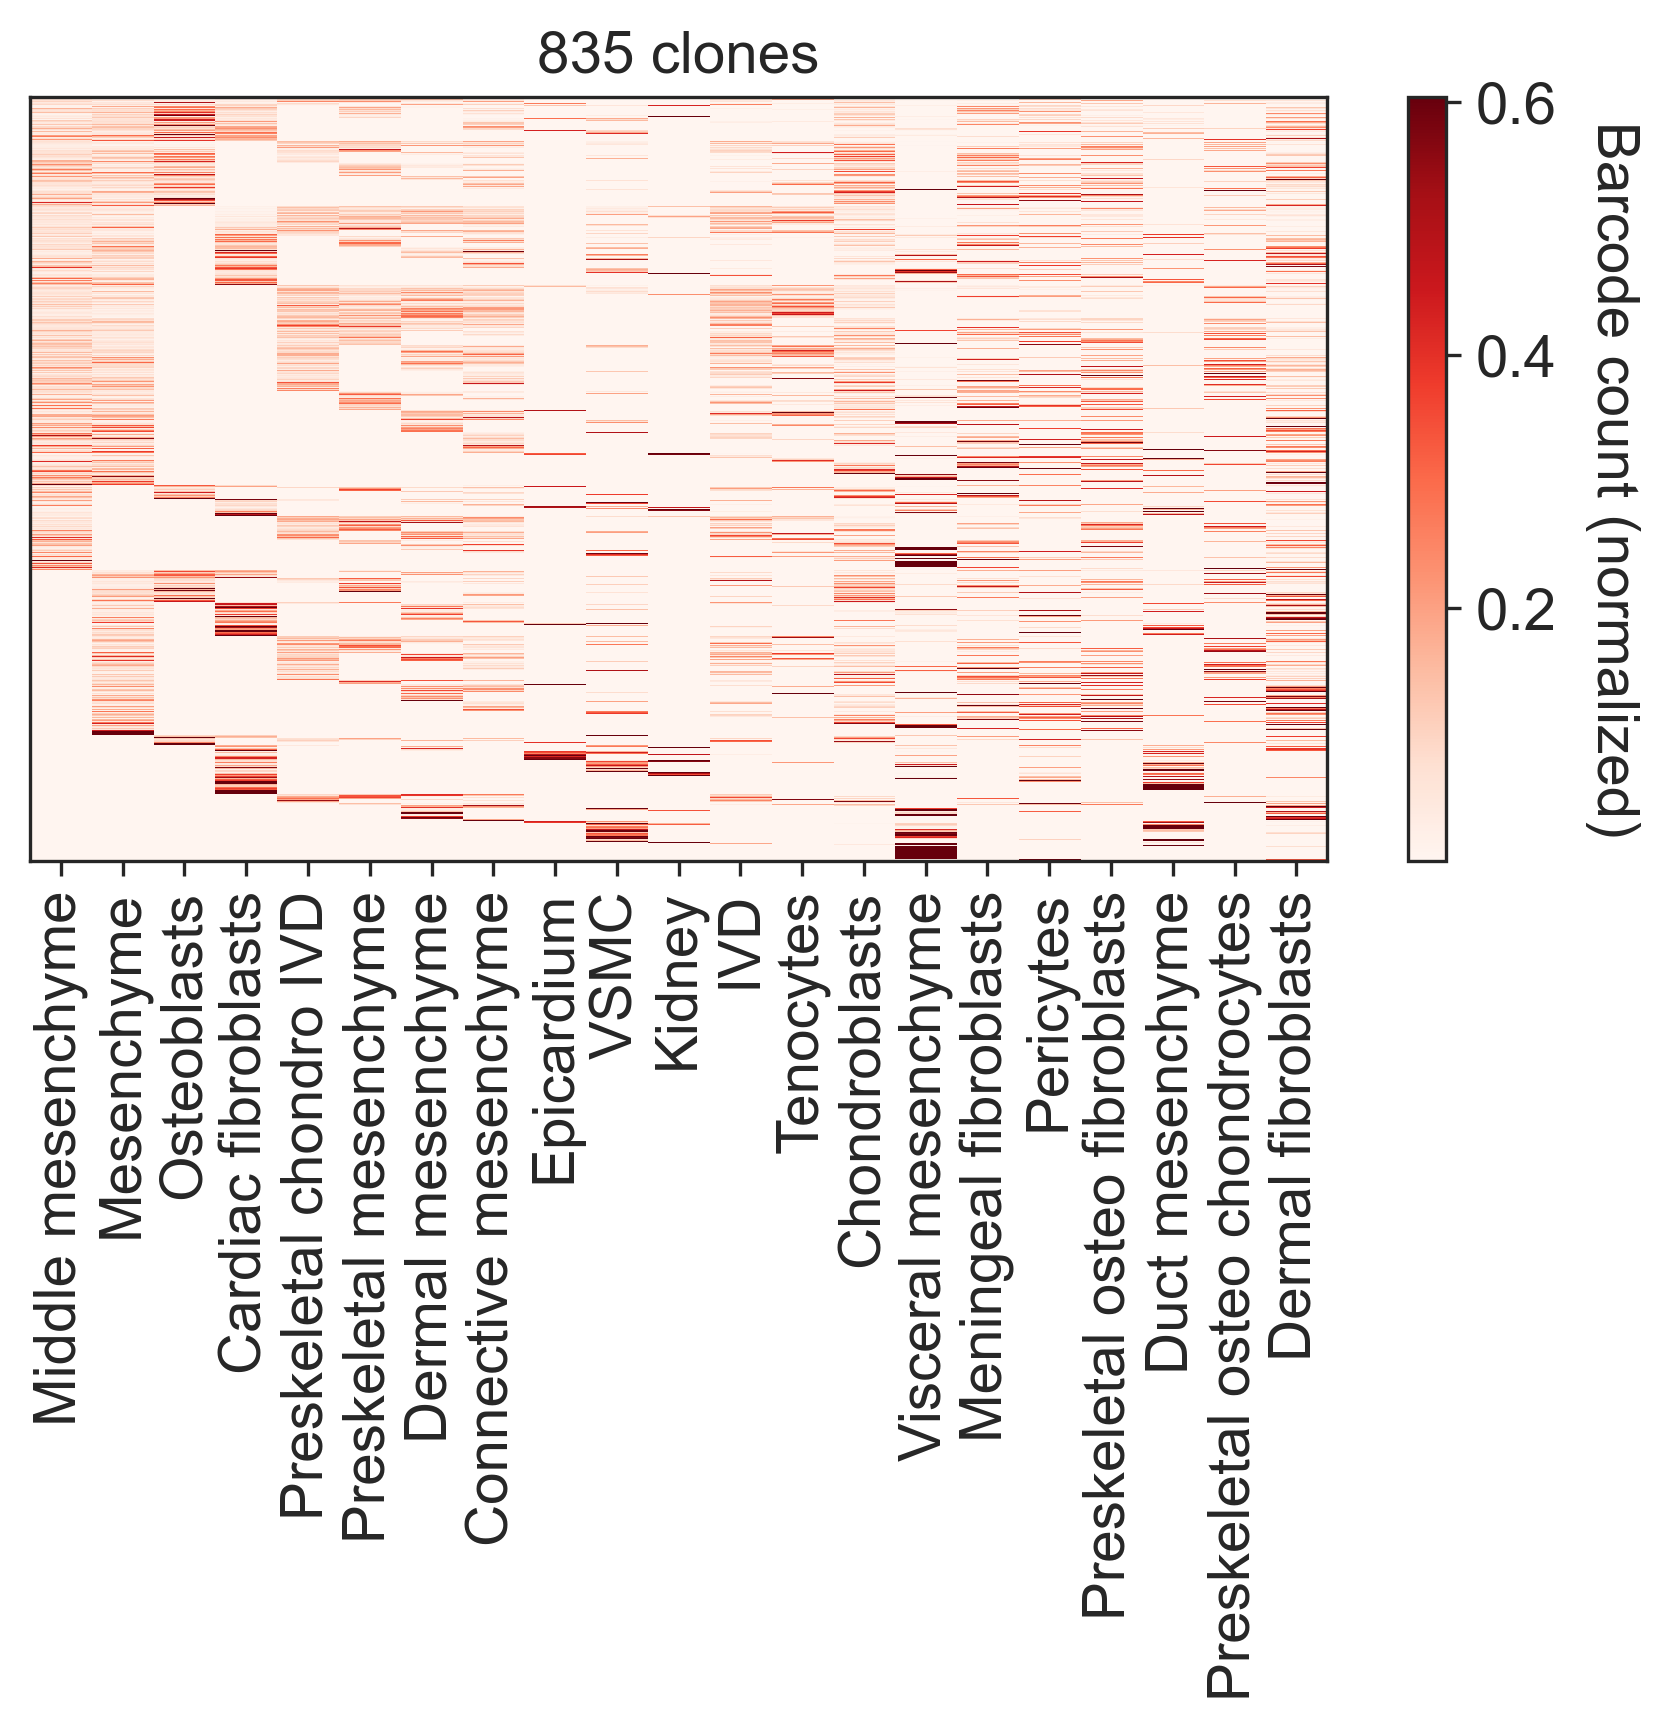

In [35]:
# Firstly, let's check an output of the native cospar.pl.barcode_heatmap function

cs.pl.barcode_heatmap(adata, normalize=True, fig_width=6)

normalize by X_clone
each selected cluster has a unique time point. Normalize per time point


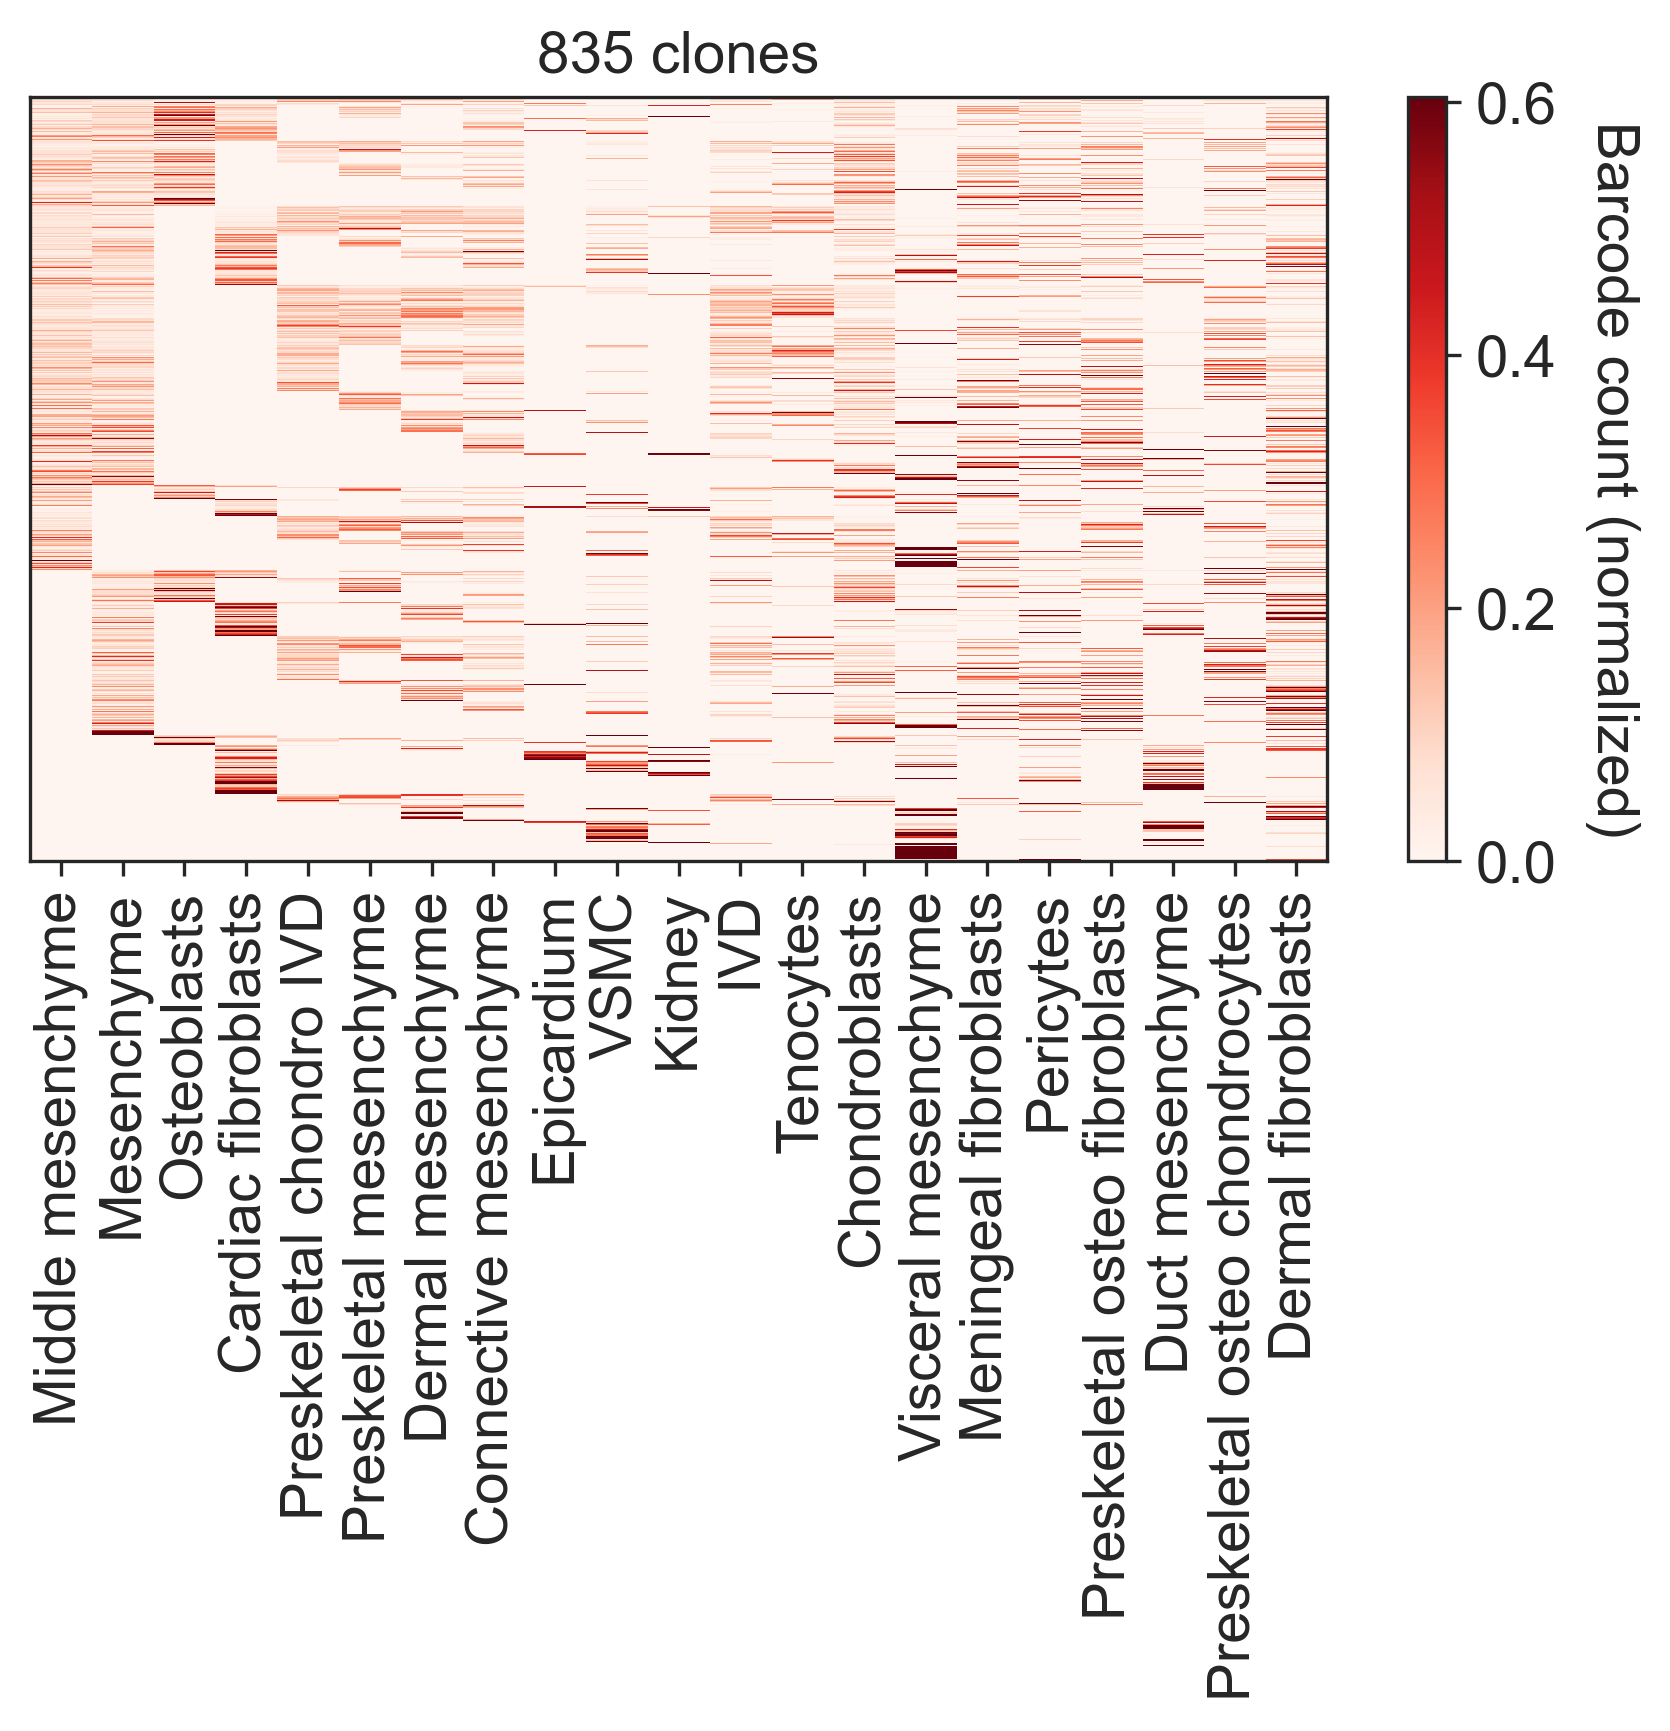

In [36]:
# Let's compare an output from the modified function to the
# previous function

coarse_X_clone_new, order_new = barcode_heatmap(
    adata,
    normalize=True,
    fig_width=6,
)

In [37]:
# Okey, looks similar. Let's assign the new proportions and to the clones object
# and order it according to the order on the heatmap

clones_cospar = clones[:, adata.uns["barcode_heatmap"]["fate_names"]].copy()
clones_cospar.X = adata.uns["barcode_heatmap"]["coarse_X_clone"].T
clones_cospar = clones_cospar[order_new].copy()

<Axes: title={'center': 'Osteoblasts (Our norlamization)'}, xlabel='UMAP1', ylabel='UMAP2'>

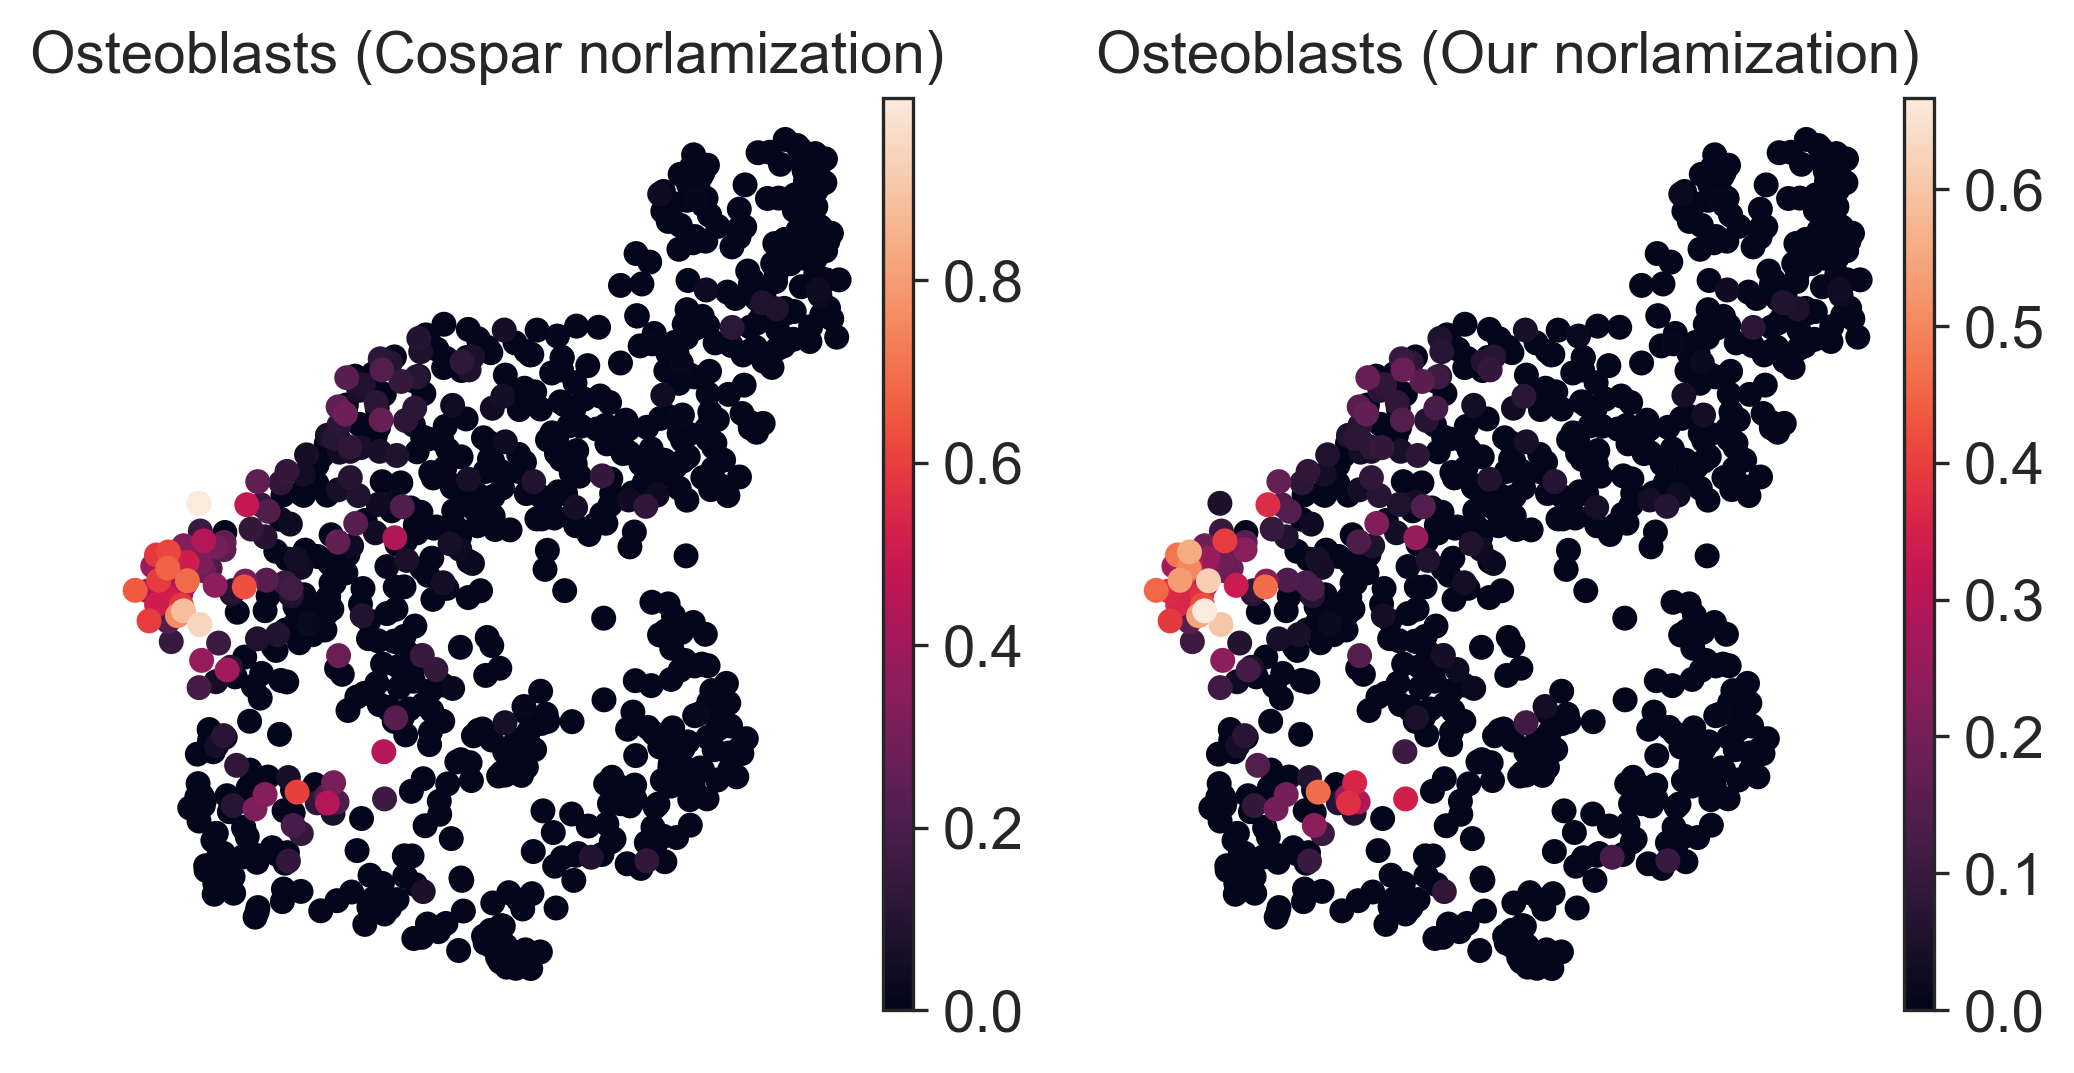

In [41]:
# Let's check that we didn't skrew up the order of the clones — check proportion
# of some obvious cell type

fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

sc.pl.umap(clones_cospar, color="Osteoblasts", ax=axes[0], show=False, frameon=False,
           title="Osteoblasts (Cospar norlamization)")

sc.pl.umap(clones, color="Osteoblasts", ax=axes[1], show=False, frameon=False,
           title="Osteoblasts (Our norlamization)", layer="frequencies")

In [130]:
# Looks nice. Let's visualize clonal clusters on the heatmap annotation

import matplotlib.patches as mpatches

color = [
    sns.color_palette()[int(i)]
    for i in clones.obs.leiden_1
]

legend_handles = [
    mpatches.Patch(color=sns.color_palette()[int(i)], label=i)
    for i in list(set(clones.obs.leiden_1))
]

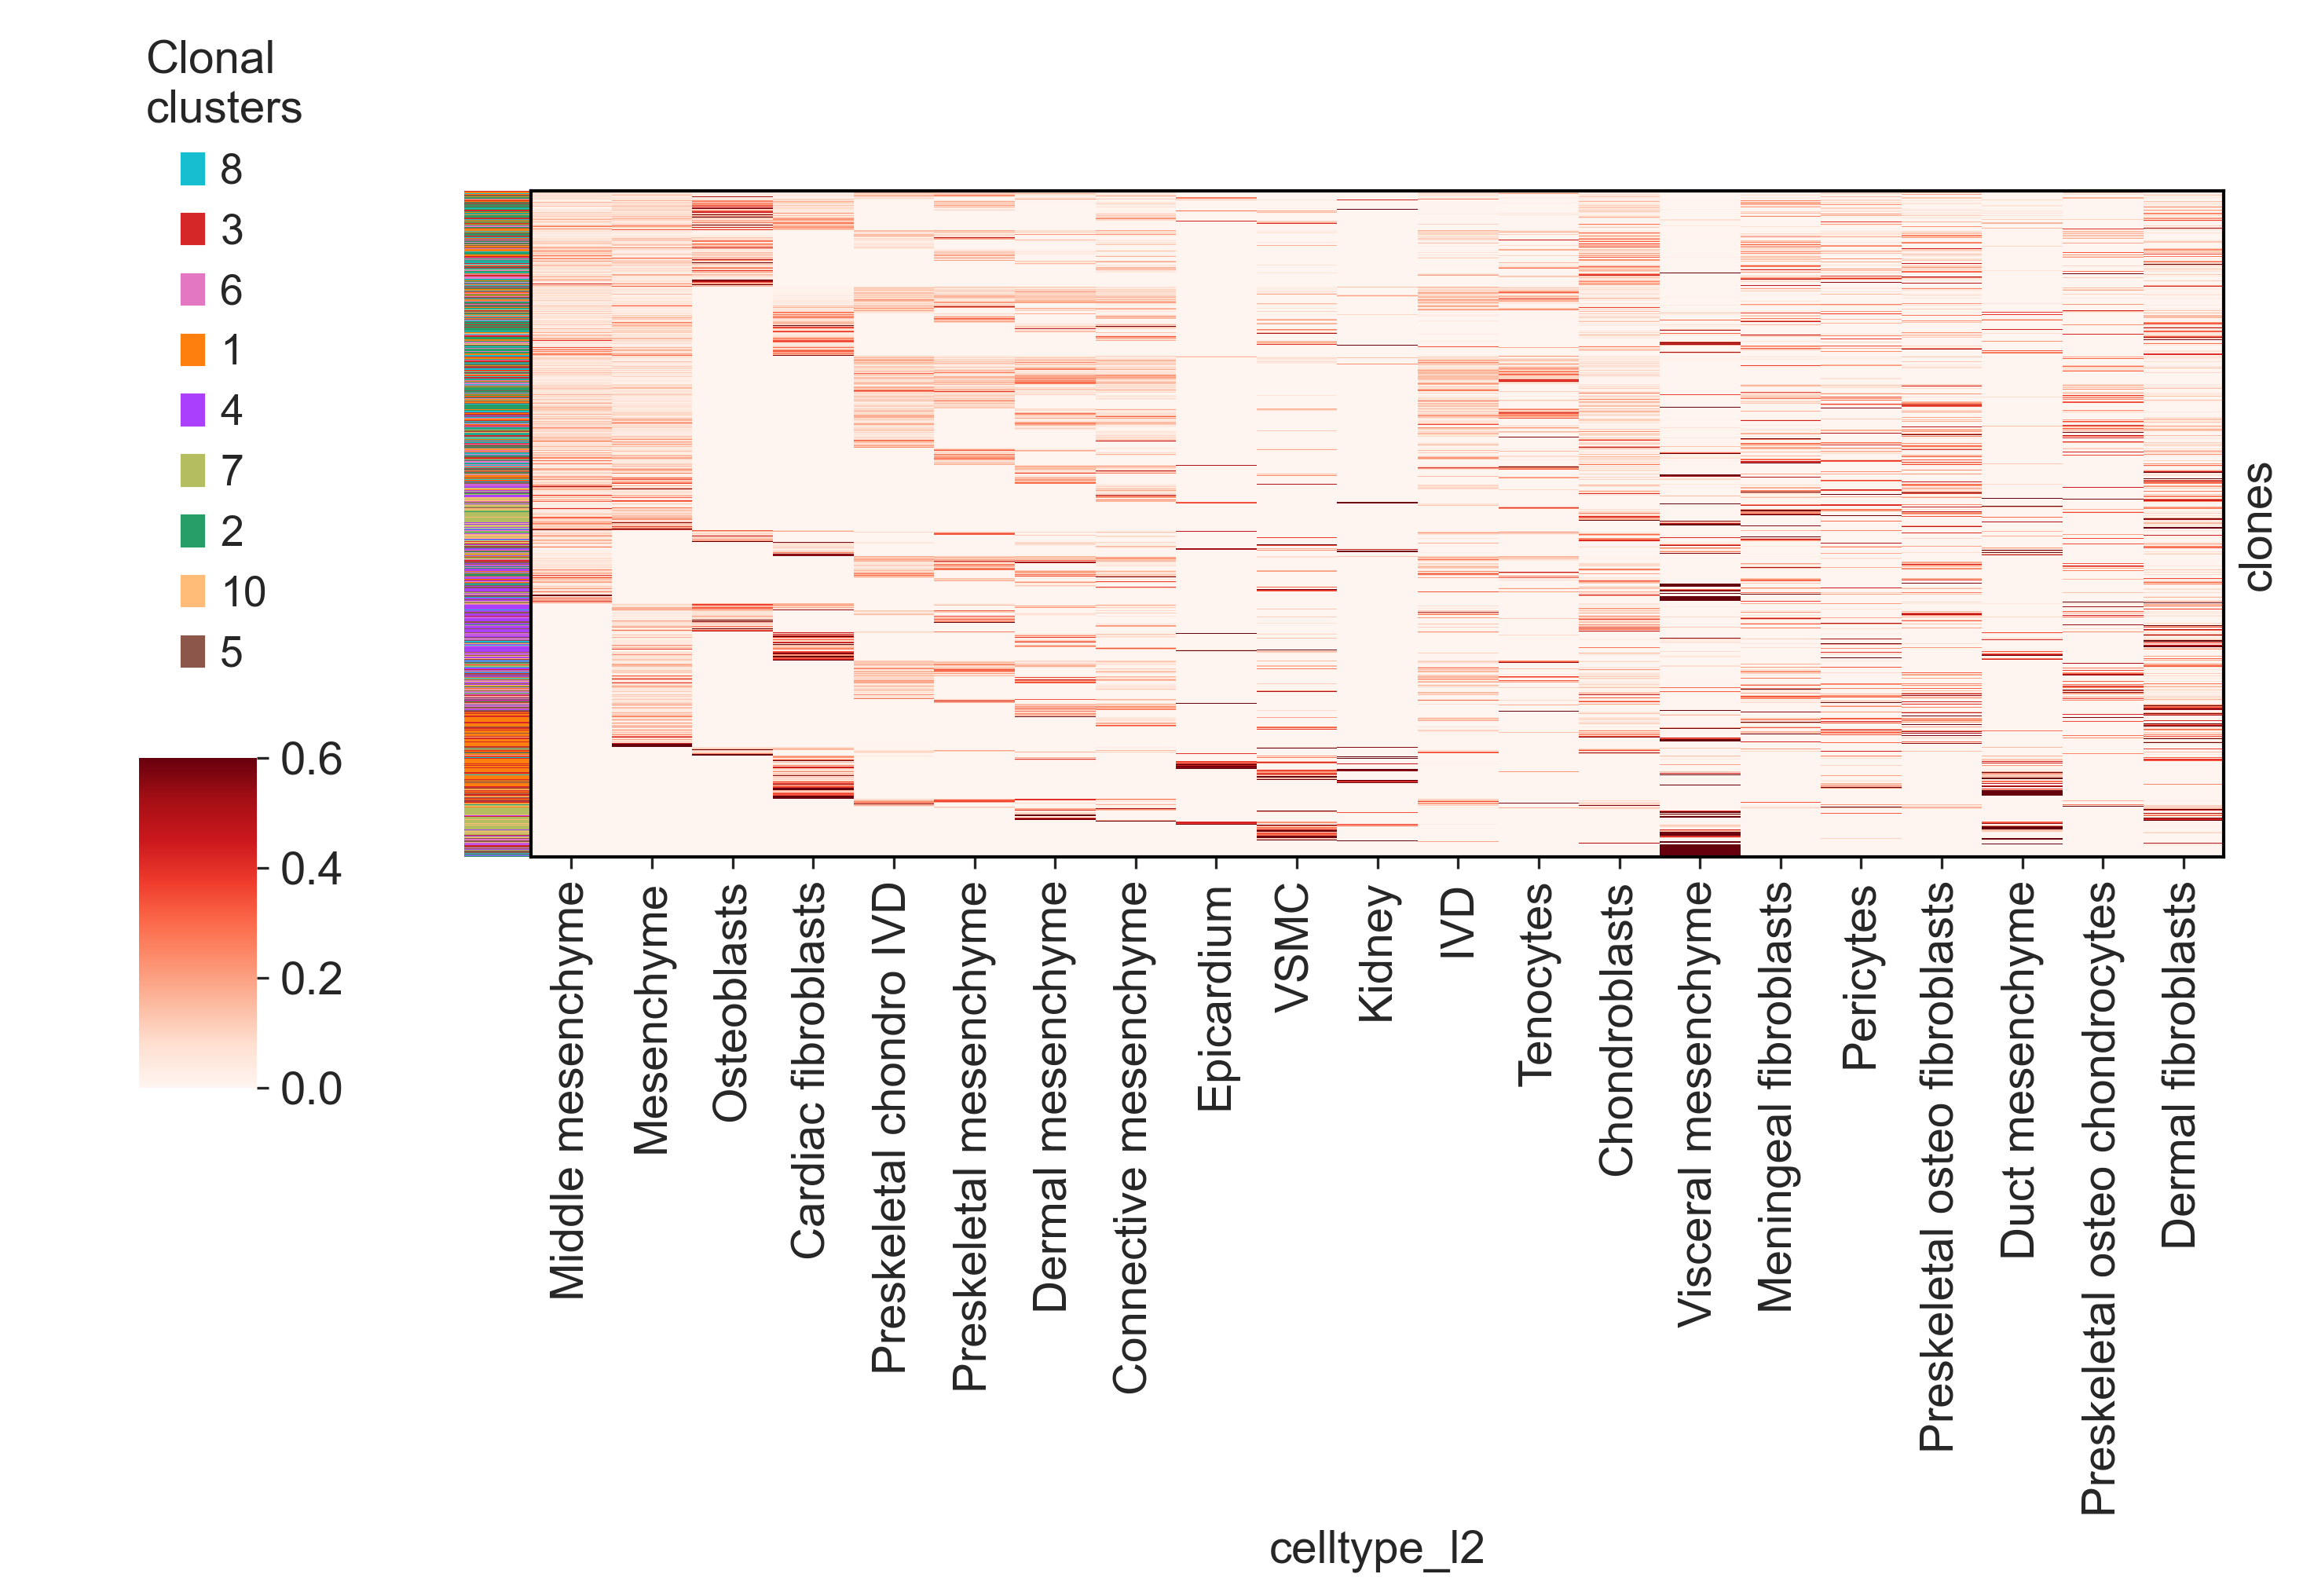

In [147]:
g = sns.clustermap(
    clones_cospar.to_df(),
    cmap="Reds",
    vmax=0.6,
    col_cluster=False,
    row_cluster=False,
    yticklabels=0,
    row_colors=color,
    cbar_pos=(0.07, 0.325, 0.05, 0.2),
    figsize=(10, 7),
)

for spine in g.ax_heatmap.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor("black")
    
g.ax_heatmap.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(-0.25, 0.75),
    title="Clonal\nclusters",
    edgecolor="white",
)

plt.savefig("figure/barcode_heatmap.pdf", bbox_inches="tight")

In [107]:
# Let's check the distribution of the Hox-score across the heatmap

clones_cospar.obs["Hox_position"] = clones_expr[clones_cospar.obs_names].obs["Hox_position"].values
clones_cospar.obs["new_order"] = np.arange(len(clones_cospar))

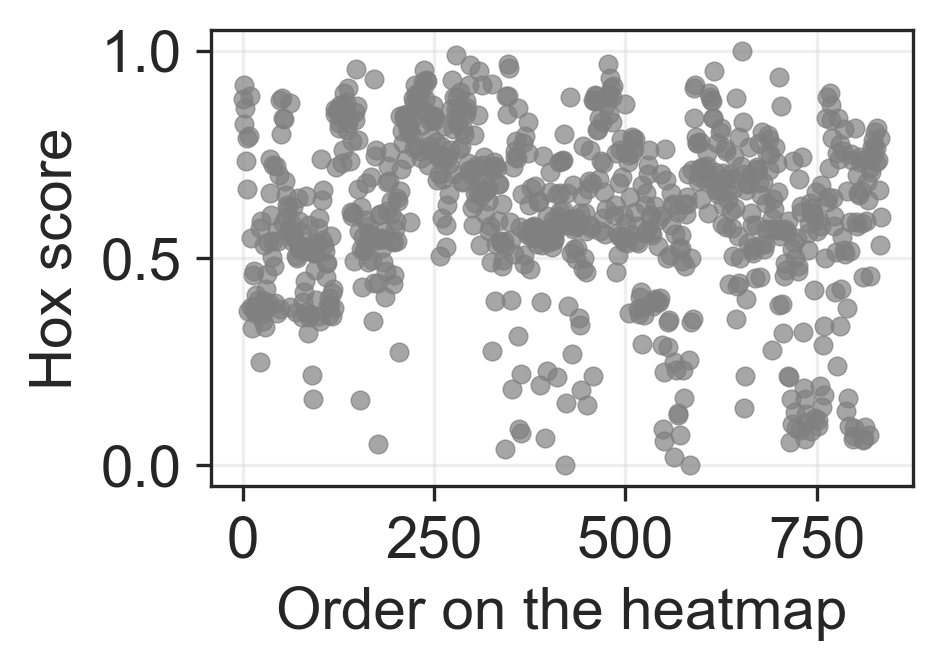

In [123]:
fig, ax = plt.subplots(figsize=(3, 2))
sns.scatterplot(
    x=clones_cospar.obs["new_order"],
    y=clones_cospar.obs["Hox_position"],
    s=20,
    ax=ax,
    edgecolor=None,
    color="grey",
    alpha=0.7,
)

ax.set_xlabel("Order on the heatmap")
ax.set_ylabel("Hox score")
ax.grid(alpha=0.3)

normalize by X_clone
each selected cluster has a unique time point. Normalize per time point
Data saved at adata.uns['barcode_heatmap']


<Axes: title={'center': '506 clones'}>

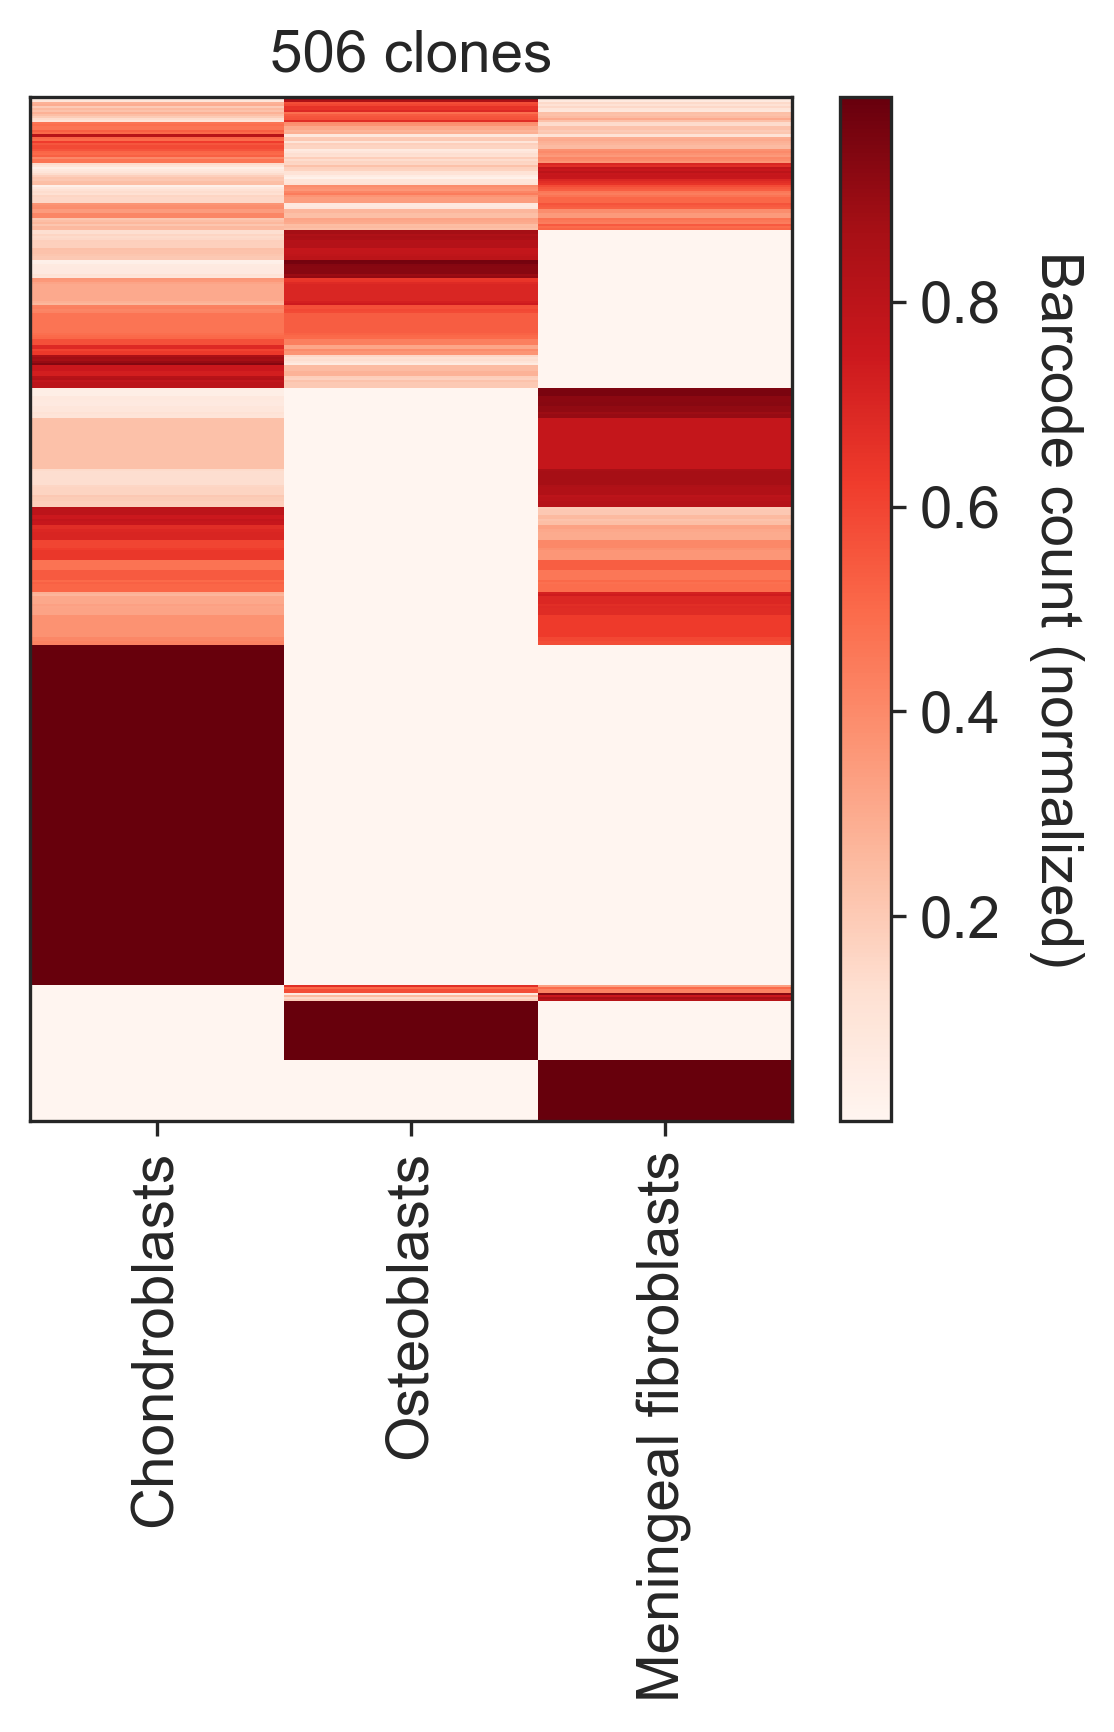

In [95]:
# Maybe it's better to work with three selected fates?

cs.pl.barcode_heatmap(
    adata,
    selected_fates=["Chondroblasts", "Osteoblasts", "Meningeal fibroblasts"],
    select_clones_with_fates=["Chondroblasts", "Osteoblasts", "Meningeal fibroblasts"],
    normalize=True,
)

In [97]:
osteo = clones[
    (clones[:, "Chondroblasts"].X.T[0] > 0) &
    (clones[:, "Osteoblasts"].X.T[0] > 0) &
    (clones[:, "Meningeal fibroblasts"].X.T[0] == 0)
].obs_names

meningeal = clones[
    (clones[:, "Chondroblasts"].X.T[0] > 0) &
    (clones[:, "Osteoblasts"].X.T[0] == 0) &
    (clones[:, "Meningeal fibroblasts"].X.T[0] > 0)
].obs_names

clones.obs["chondro_osteo"] = [
    "osteo" if i in osteo else
    "meningeal" if i in meningeal else
    "other" for i in clones.obs_names
]
sl.tl.transfer_clonal_annotation(
    adata,
    clones,
    "clone",
    "chondro_osteo",
    "chondro_osteo",
)

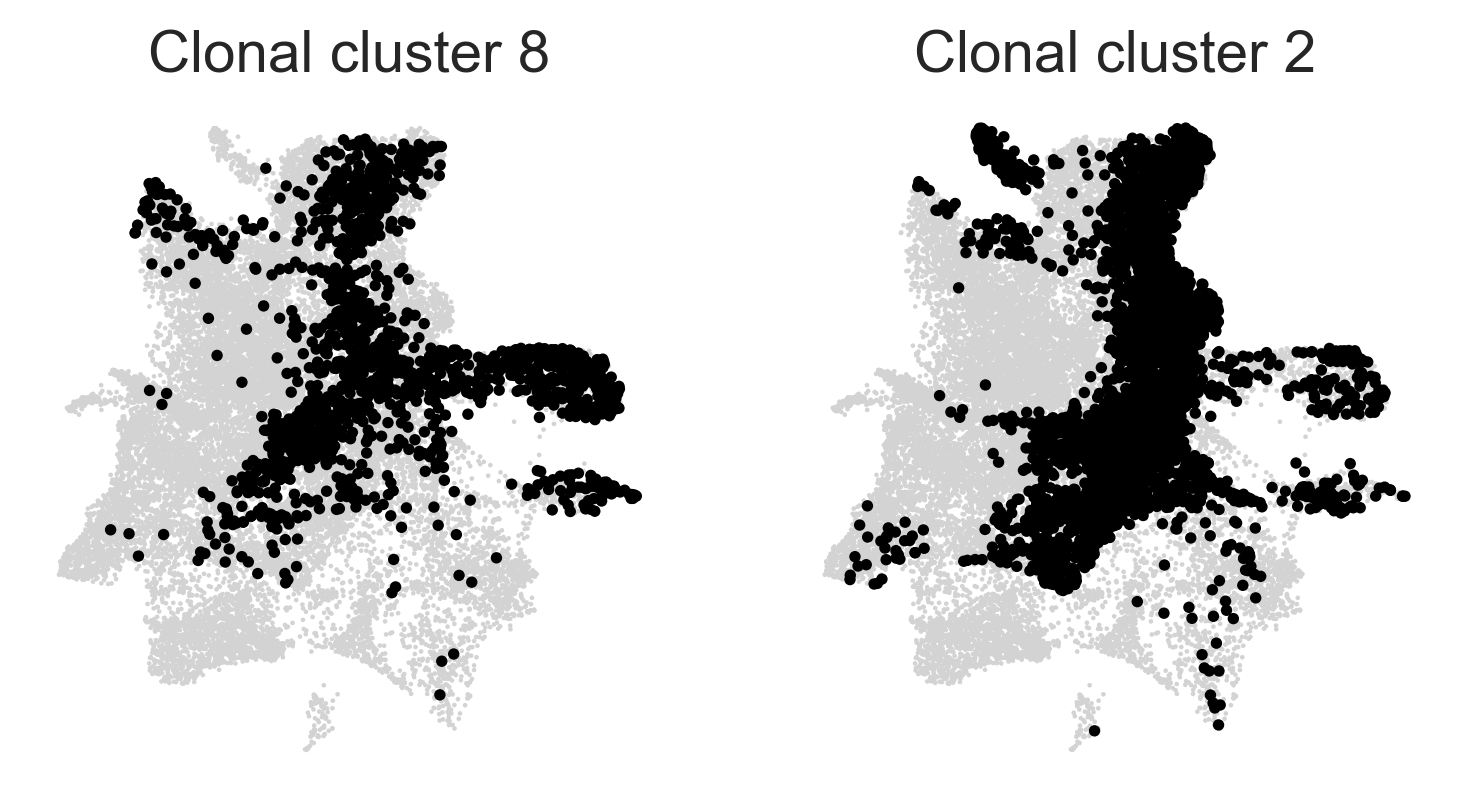

In [126]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 3))
sl.pl.clone(adata, "clones_clusters_1", "8",
            title="Clonal cluster 8", ax=axes[0])
sl.pl.clone(adata, "clones_clusters_1", "2",
            title="Clonal cluster 2", ax=axes[1])

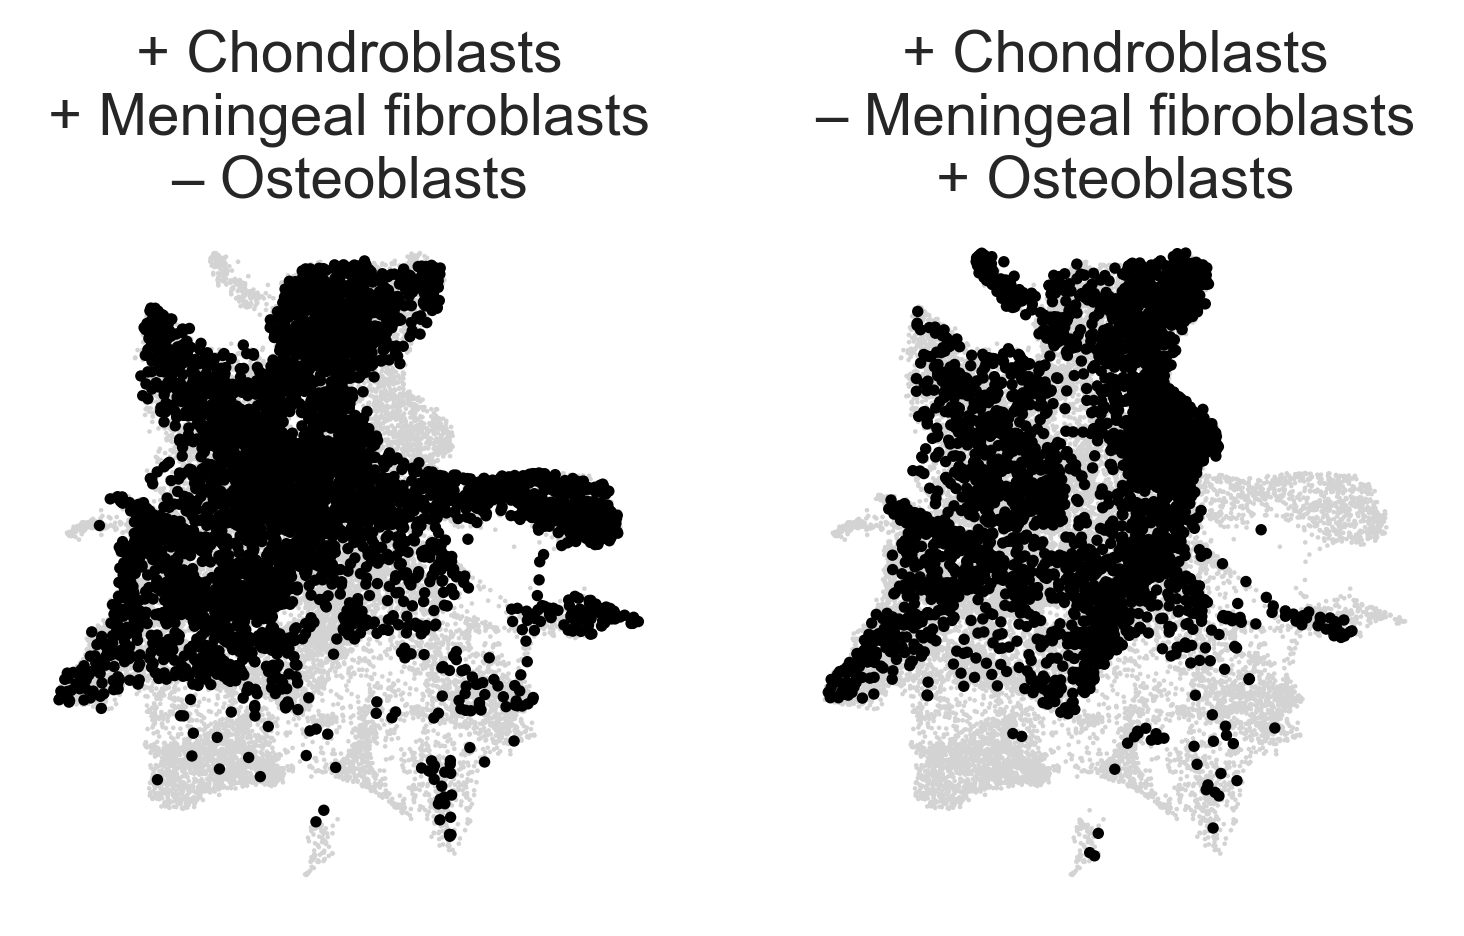

In [101]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 3))
sl.pl.clone(adata, "chondro_osteo", "meningeal",
            title="+ Chondroblasts\n+ Meningeal fibroblasts\n– Osteoblasts", ax=axes[0])
sl.pl.clone(adata, "chondro_osteo", "osteo",
            title="+ Chondroblasts\n– Meningeal fibroblasts\n+ Osteoblasts", ax=axes[1])

In [442]:
clones.write_h5ad("reordered_clones.h5ad")